In [1]:
import torch
import torch.nn as nn
import torch.distributions as D
import torchvision
from tqdm import tqdm_notebook
import torchvision.transforms as transforms
#from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import pdb

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Loading MNIST dataset

In [3]:
batch_size = 100

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

In [5]:
trainloader.dataset.train_data.shape, testloader.dataset.test_data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

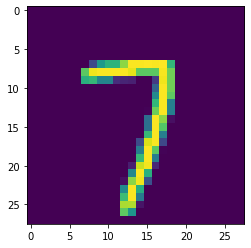

In [6]:
i = np.random.randint(low=0, high=60000)
plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap=None)

In [7]:
X_train, y_train = trainloader.dataset.train_data, trainloader.dataset.train_labels
X_text, y_test = testloader.dataset.test_data, testloader.dataset.test_labels

In [8]:
device = "cpu" if torch.cuda.is_available() else "cuda:0"

In [9]:
device

'cpu'

In [10]:
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32), #for sampling
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

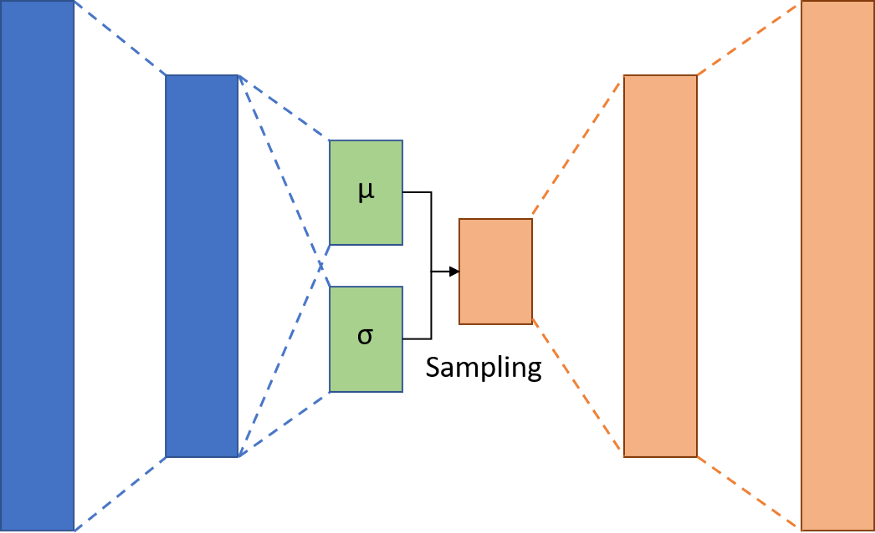

In [35]:
class VAE(nn.Module):
    def __init__(self, beta=1):
        super(VAE, self).__init__()
        self.hidden_size = 64
        self.encoder = nn.Sequential(nn.Flatten(),
                                     nn.Linear(784,392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
                                     nn.Linear(392, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
                                     nn.Linear(196, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
                                     nn.Linear(128, self.hidden_size))
        
        self.hidden_mu = nn.Linear(self.hidden_size, self.hidden_size)
        self.hidden_log_var = nn.Linear(64, self.hidden_size)
        
        self.decoder = nn.Sequential(nn.Linear(self.hidden_size, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
                                     nn.Linear(128, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
                                     nn.Linear(196, 392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
                                     nn.Linear(392, 784),
                                     #nn.Unflatten(),
                                     #reshape back to 28,28
                                     nn.Tanh())
        self.beta = beta # in case of disentangled VAE !=1 and is passed as a parameter
        
        
    def distrN(self, mu, covar):
        g = D.Normal(loc=mu.sum(1).mean(), scale=covar.sum(1).mean())
        return g
        
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden_mu(hidden)
        log_var = self.hidden_log_var(hidden) # getting mu and sigma for reparametrization trick
        return mu, log_var

    def reparametrize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        #z = std_normal.sample((sigma.size[0],self.hidden_size)) # TODO: fix the sample shape
        z = torch.randn_like(sigma) # get normal distribution size of sigma
        return torch.sqrt(sigma) * z + mu
    
    def decode(self, x):
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        hidden = self.reparametrize(mu, log_var) # bottleneck
        output = self.decoder(hidden) # x_out
        return mu, log_var, output 

In [36]:
net = VAE()

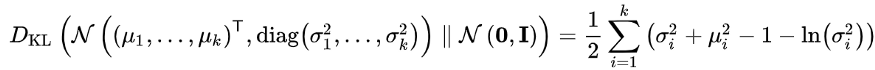

In [37]:
optimizer = torch.optim.Adagrad(params = net.parameters())
#optimizer = torch.optim.Adam(params = net.parameters())
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

In [38]:
def loss_fn(mu, log_var, x_out, x):
        kl_loss = -(0.5*(1 + log_var - mu**2 - torch.exp(log_var)).sum(1)).mean()
        #recon_loss = std_normal.log_prob(x_out).sum(1).mean()/batch_size # x_out = z
        #recon_loss = self.distrN(mu, log_var).log_prob(x).sum(1).mean()/batch_size
        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)
        loss = recon_loss + kl_loss
        return loss

In [40]:
running_loss = 0.0
losses=[]
test_losses = []
for i, batch in enumerate(tqdm_notebook(trainloader)):   
    net.train(True)
    optimizer.zero_grad()

    x, _ = batch
    mu, log_var, x_out = net.forward(x)
    #kl_loss = (0.5*(- 1 - log_var + mu**2 + torch.exp(log_var)).sum(1)).mean()#- 0.5 * ((torch.exp(log_var) + mu**2 - 1 - log_var).sum(1)).mean()
    #recon_loss = std_normal.log_prob(x_out).sum(0).mean()
    #loss = recon_loss + kl_loss
    #loss = net.loss_fn(mu, log_var, x_out.reshape((100,28,28)), x)
    loss = loss_fn(mu, log_var, x_out.reshape((100,28,28)), x)
    
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
        losses.append(running_loss/100)
        running_loss = 0.0
    
    net.train(False)
    with torch.no_grad():
        mu, log_var, x_out = net.forward(x)
        test_losses.append(loss_fn(mu, log_var, x_out.reshape((100,28,28)),x).item())

  0%|          | 0/600 [00:00<?, ?it/s]

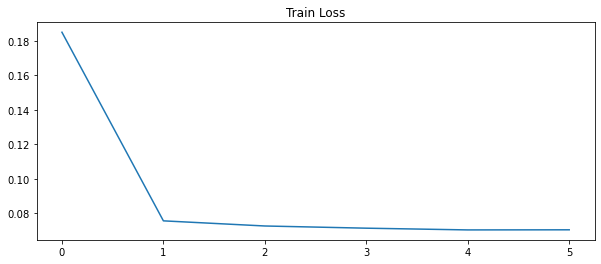

In [41]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(losses)), losses)
plt.title("Train Loss")
plt.show()

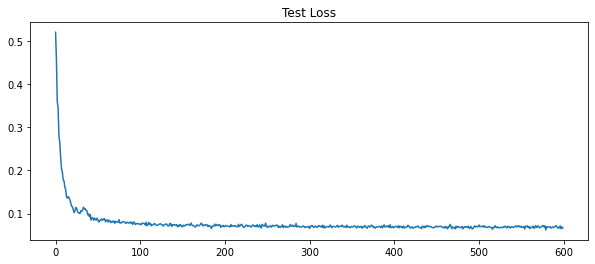

In [42]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(test_losses)), test_losses)
plt.title("Test Loss")
plt.show()

In [43]:
sum(losses)/len(losses), sum(test_losses)/len(test_losses)

(0.09083432408670584, 0.07768106032162905)

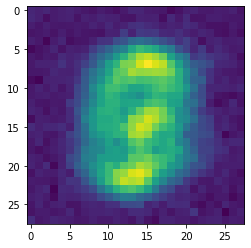

In [53]:
i = np.random.randint(low=0, high=99)
plt.imshow(x_out[i].reshape((28,28)).detach().numpy(), cmap=None)